In [1]:
import scanpy as sc
import pandas as pd

In [2]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor="white")

scanpy==1.10.1 anndata==0.10.7 umap==0.5.6 numpy==1.24.3 scipy==1.11.1 pandas==2.0.3 scikit-learn==1.3.0 statsmodels==0.14.0 igraph==0.11.4 pynndescent==0.5.12


In [3]:
results_file = "A2780_scanpy.h5ad"

In [4]:
adata = sc.read_10x_mtx(
    "A2780/",  # the directory with the `.mtx` file
    var_names="gene_symbols",  # use gene symbols for the variable names (variables-axis index)
    cache=True,  # write a cache file for faster subsequent reading
)

... reading from cache file cache\A2780-matrix.h5ad


In [5]:
adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`

In [6]:
adata

AnnData object with n_obs × n_vars = 3870 × 33538
    var: 'gene_ids'

## QC

In [7]:
adata.var["mt"] = adata.var_names.str.startswith("MT-")

In [8]:
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt"], inplace=True, log1p=False)

In [9]:
mean_value_feature = adata.obs['n_genes_by_counts'].dropna().mean()
sd_value_feature = adata.obs['n_genes_by_counts'].dropna().std()

In [10]:
nFeature_Upper = mean_value_feature + 2 * sd_value_feature
nFeature_Lower = 200  # As per your fixed lower threshold

In [11]:
mito_genes = adata.var_names.str.startswith('MT-')
adata.obs['percent_mito'] = adata[:, mito_genes].X.sum(axis=1) / adata.X.sum(axis=1) 

In [12]:
mean_value_perMito = adata.obs['percent_mito'].dropna().mean()
sd_value_perMito = adata.obs['percent_mito'].dropna().std()

In [13]:
perMito_Upper = mean_value_perMito + 2 * sd_value_perMito

In [14]:
filtered_adata = adata[
    (adata.obs['n_genes_by_counts'] > nFeature_Lower) & 
    (adata.obs['n_genes_by_counts'] < nFeature_Upper) & 
    (adata.obs['percent_mito'] < perMito_Upper)
]

In [15]:
# adata = adata[adata.obs.n_genes_by_counts < 2500, :]
# adata = adata[adata.obs.pct_counts_mt < 5, :].copy()

In [16]:
filtered_adata

View of AnnData object with n_obs × n_vars = 3449 × 33538
    obs: 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt', 'percent_mito'
    var: 'gene_ids', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

## Plots

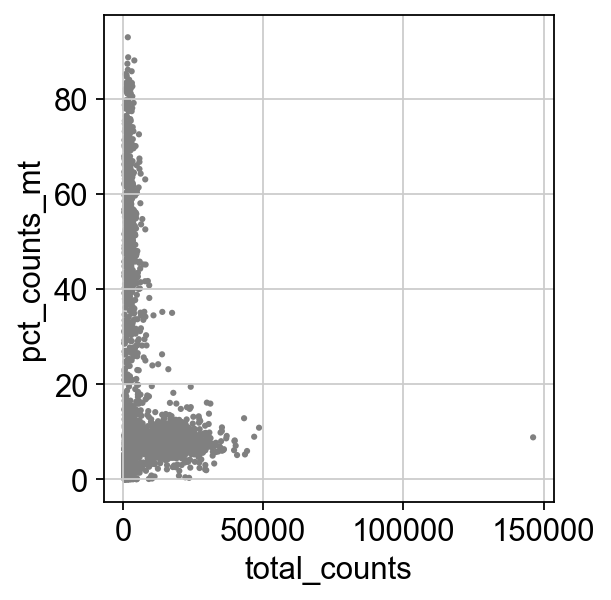

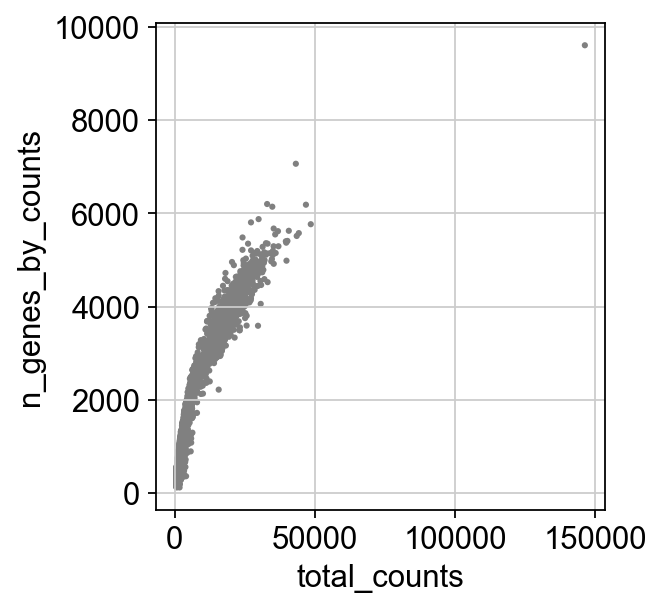

In [17]:
sc.pl.scatter(adata, x="total_counts", y="pct_counts_mt")
sc.pl.scatter(adata, x="total_counts", y="n_genes_by_counts")

C:\Users\xch\anaconda3\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


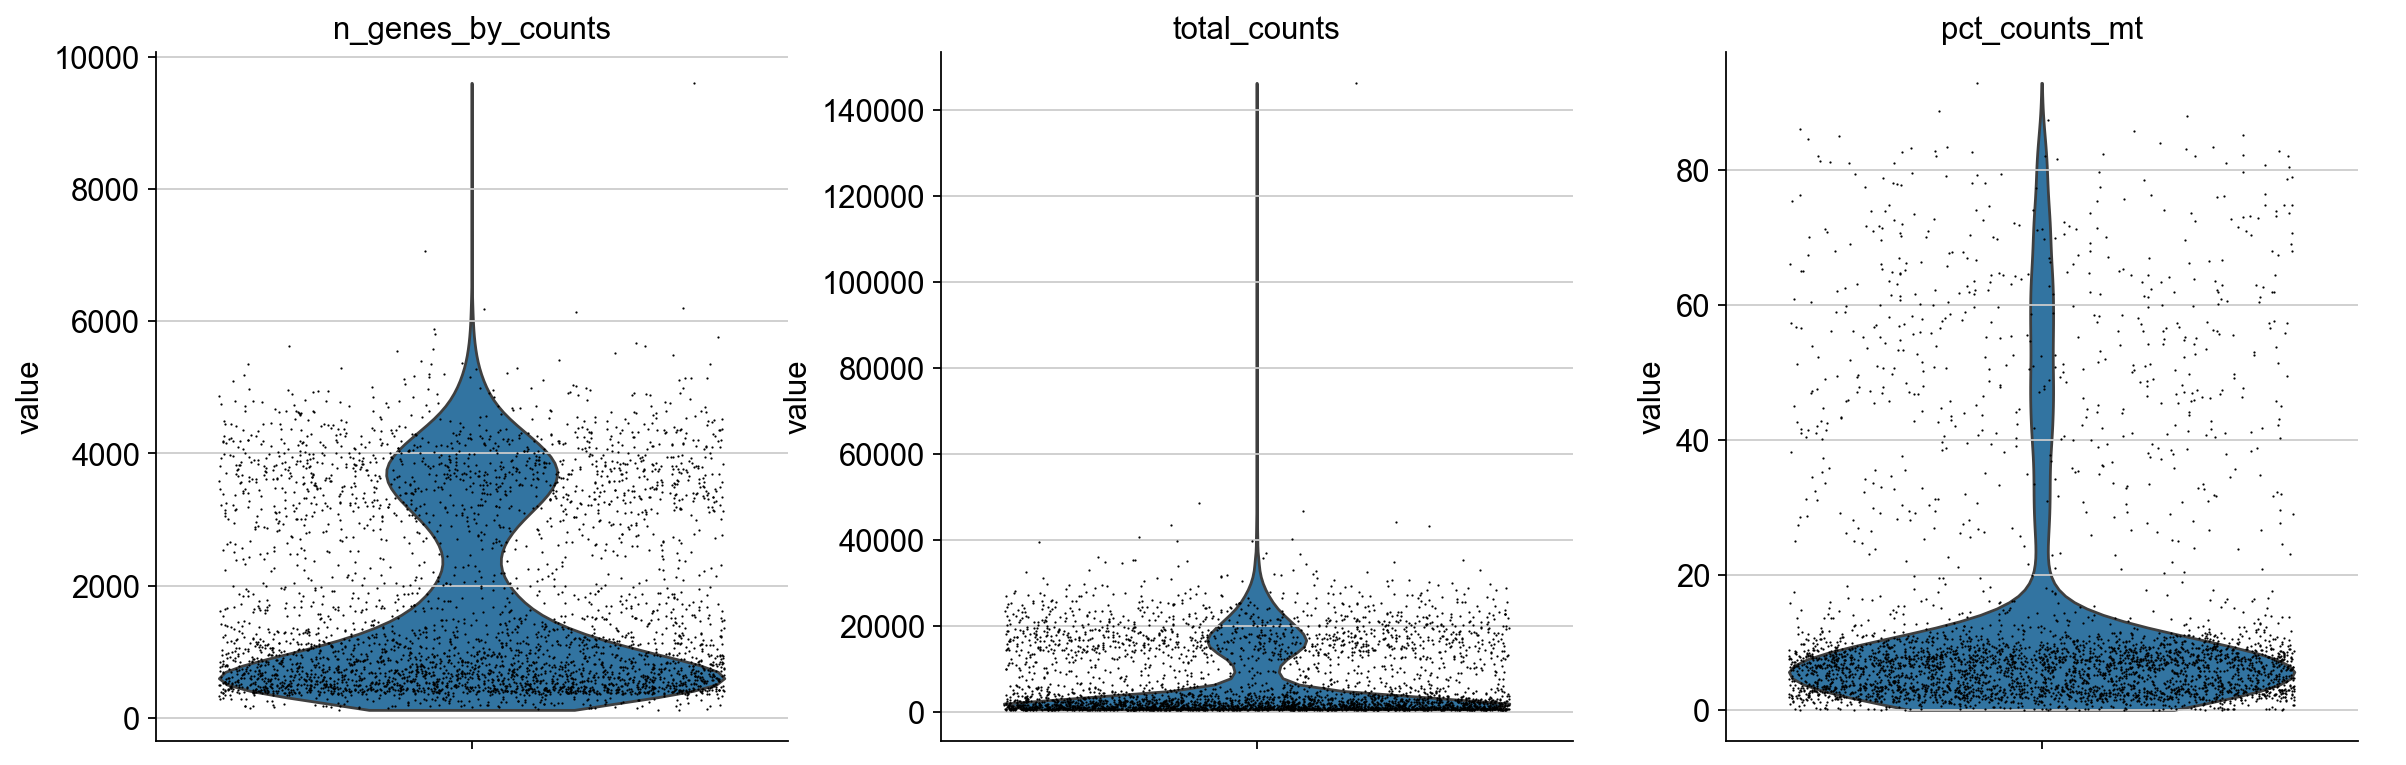

In [18]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

## Normalization

In [19]:
sc.pp.normalize_total(filtered_adata, target_sum=1e4)

normalizing counts per cell
    finished (0:00:00)


C:\Users\xch\anaconda3\Lib\site-packages\scanpy\preprocessing\_normalization.py:206: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [20]:
sc.pp.log1p(filtered_adata)

## Find variable genes

In [21]:
sc.pp.highly_variable_genes(filtered_adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


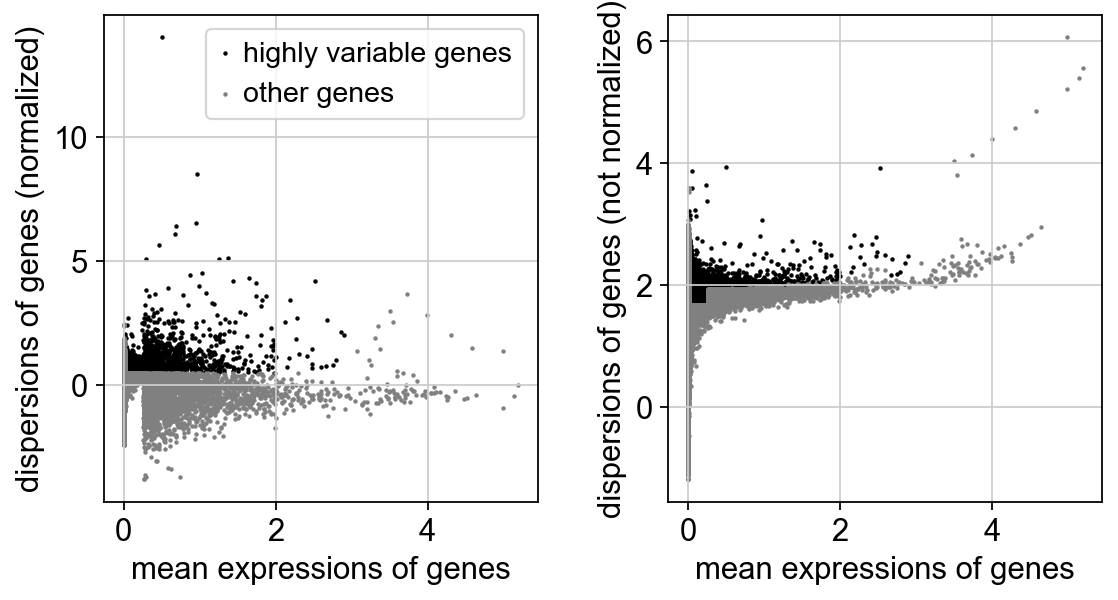

In [22]:
sc.pl.highly_variable_genes(filtered_adata)

In [23]:
n_highly_variable_genes = filtered_adata.var['highly_variable'].sum()

In [24]:
print(n_highly_variable_genes)

6157


In [25]:
filtered_adata.raw = filtered_adata

## Scale and regress out

In [26]:
sc.pp.regress_out(filtered_adata, ["total_counts", "percent_mito"])

regressing out ['total_counts', 'percent_mito']
    sparse input is densified and may lead to high memory use
    finished (0:00:21)


In [27]:
sc.pp.scale(filtered_adata, max_value=10)

## PCA

In [28]:
sc.tl.pca(filtered_adata, svd_solver="arpack", n_comps = 100)

computing PCA
    with n_comps=100
    finished (0:00:03)


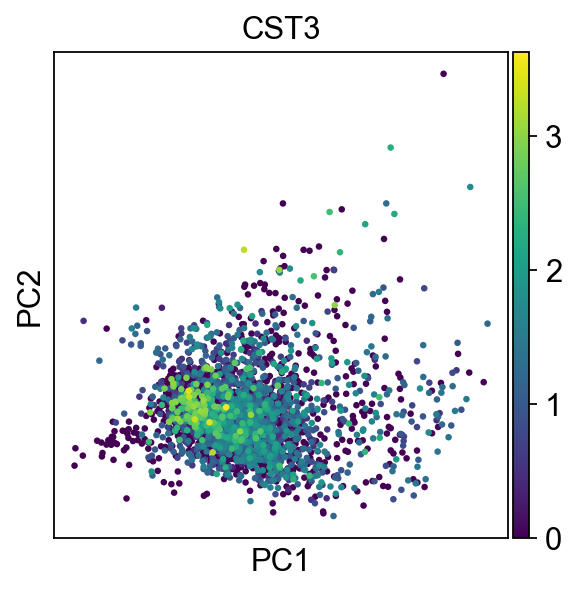

In [29]:
sc.pl.pca(filtered_adata, color="CST3")

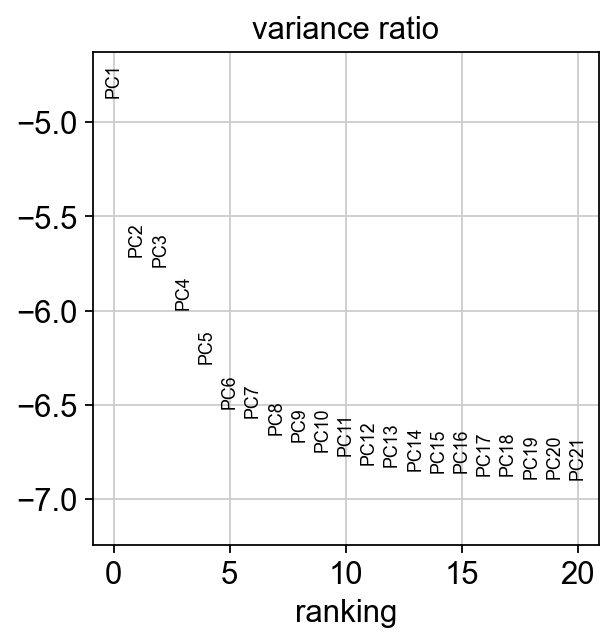

In [30]:
sc.pl.pca_variance_ratio(filtered_adata, n_pcs=20, log=True)

In [31]:
filtered_adata.write(results_file)

In [38]:
filtered_adata

AnnData object with n_obs × n_vars = 3449 × 33538
    obs: 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt', 'percent_mito', 'leiden'
    var: 'gene_ids', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'leiden'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

## Cluster

In [33]:
sc.pp.neighbors(filtered_adata, n_neighbors=100, n_pcs=50)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)


In [41]:
sc.tl.leiden(filtered_adata, resolution=0.8)

running Leiden clustering
    finished: found 6 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


In [42]:
sc.tl.paga(filtered_adata)
sc.pl.paga(filtered_adata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
sc.tl.umap(filtered_adata, init_pos='paga')

running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:05)


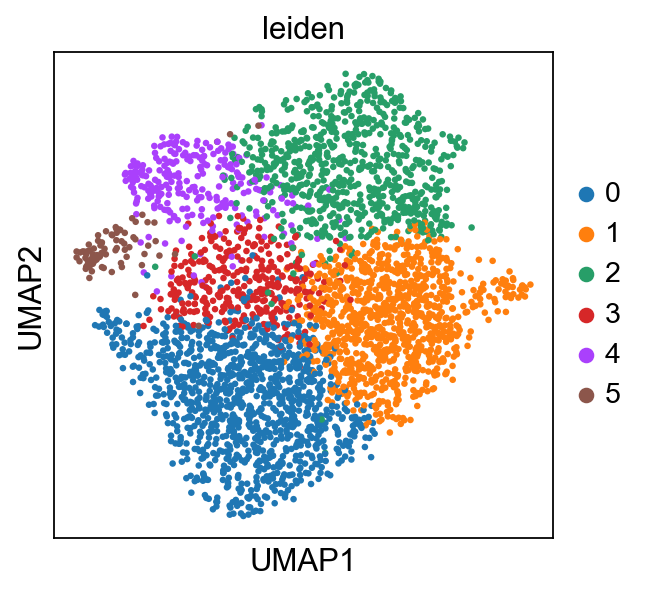

In [45]:
sc.pl.umap(filtered_adata, color=["leiden"])

In [46]:
filtered_adata.write(results_file)

## Find Markers

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


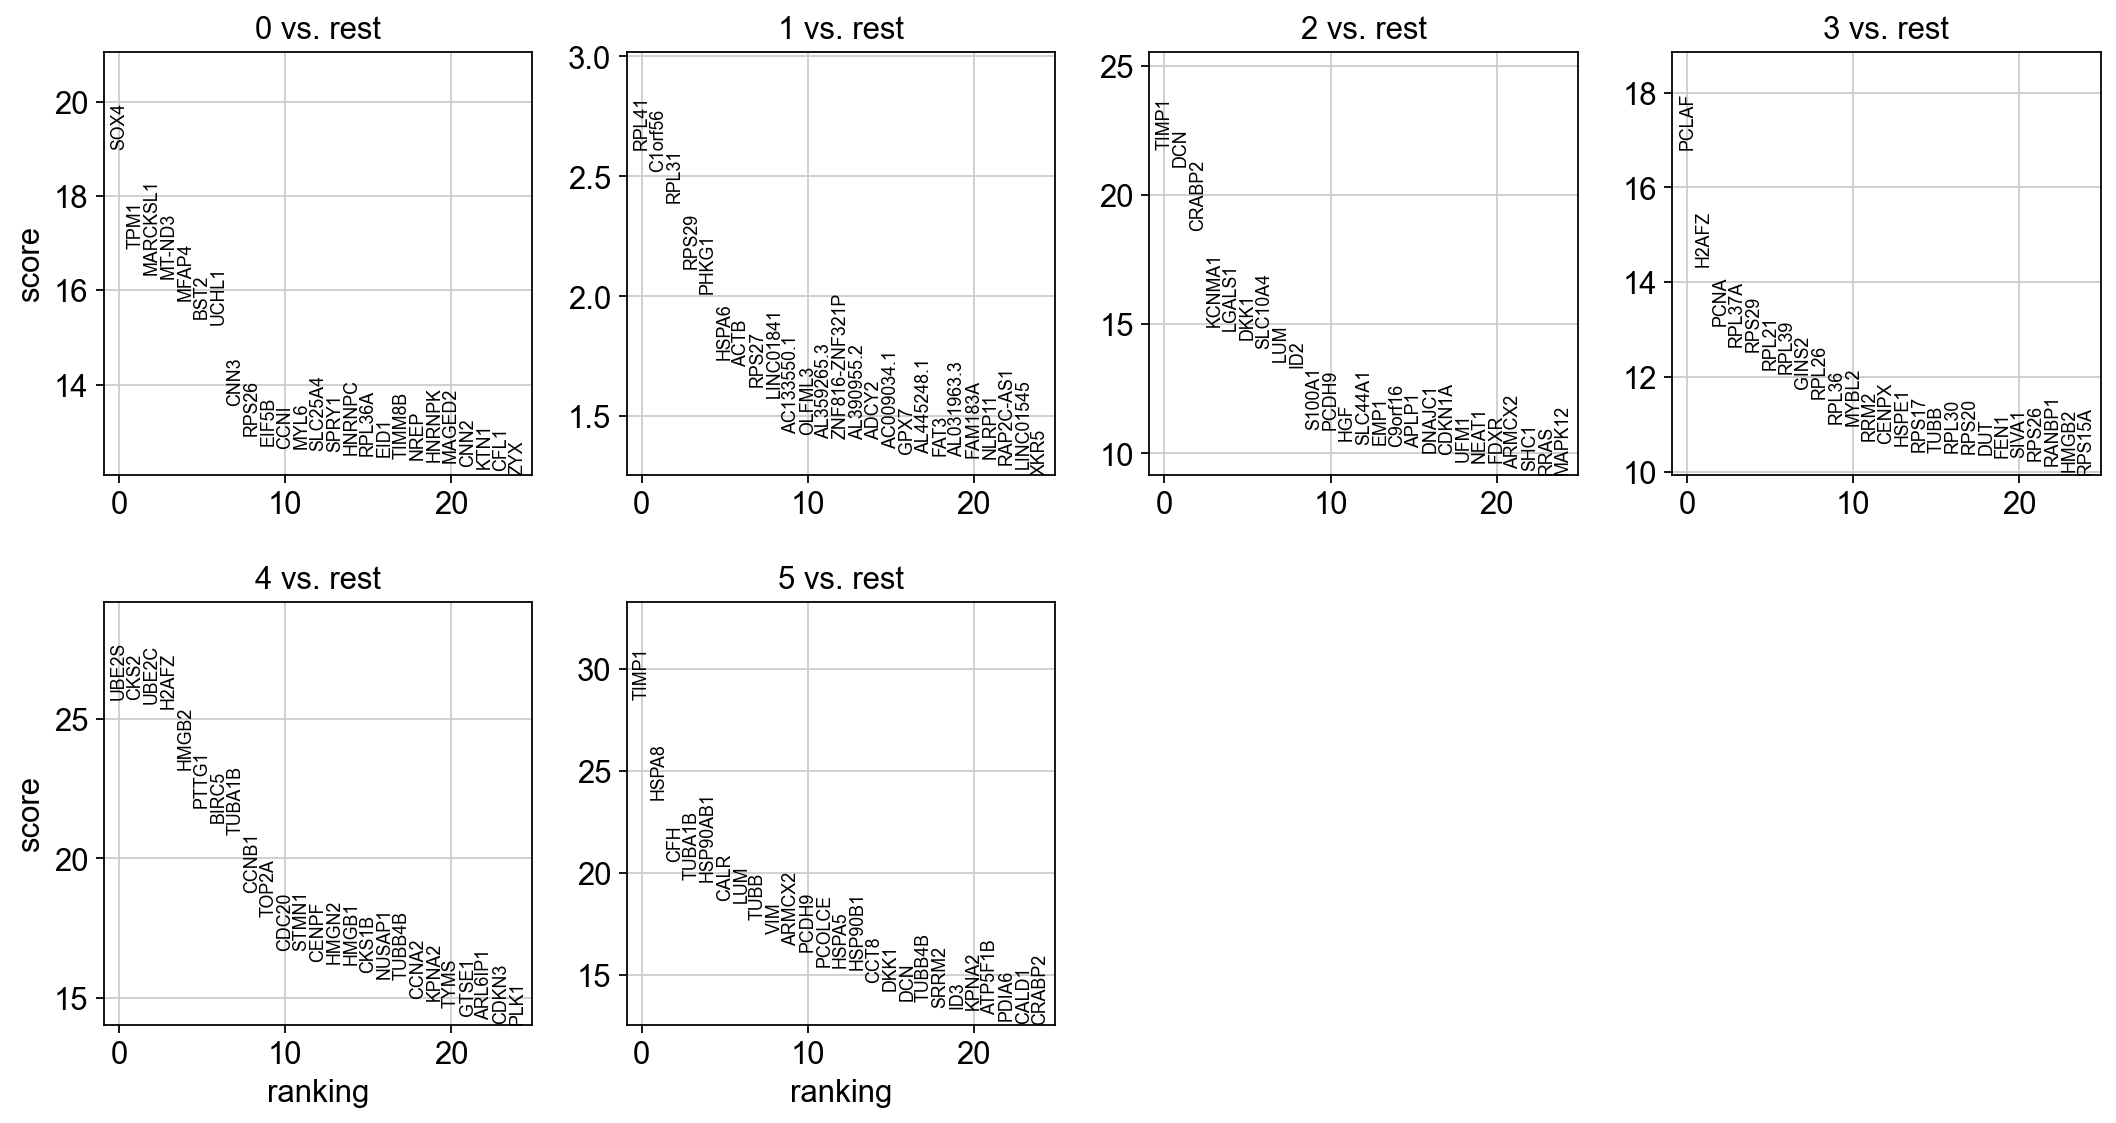

In [49]:
sc.tl.rank_genes_groups(filtered_adata, "leiden", method="t-test")
sc.pl.rank_genes_groups(filtered_adata, n_genes=25, sharey=False)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:04)


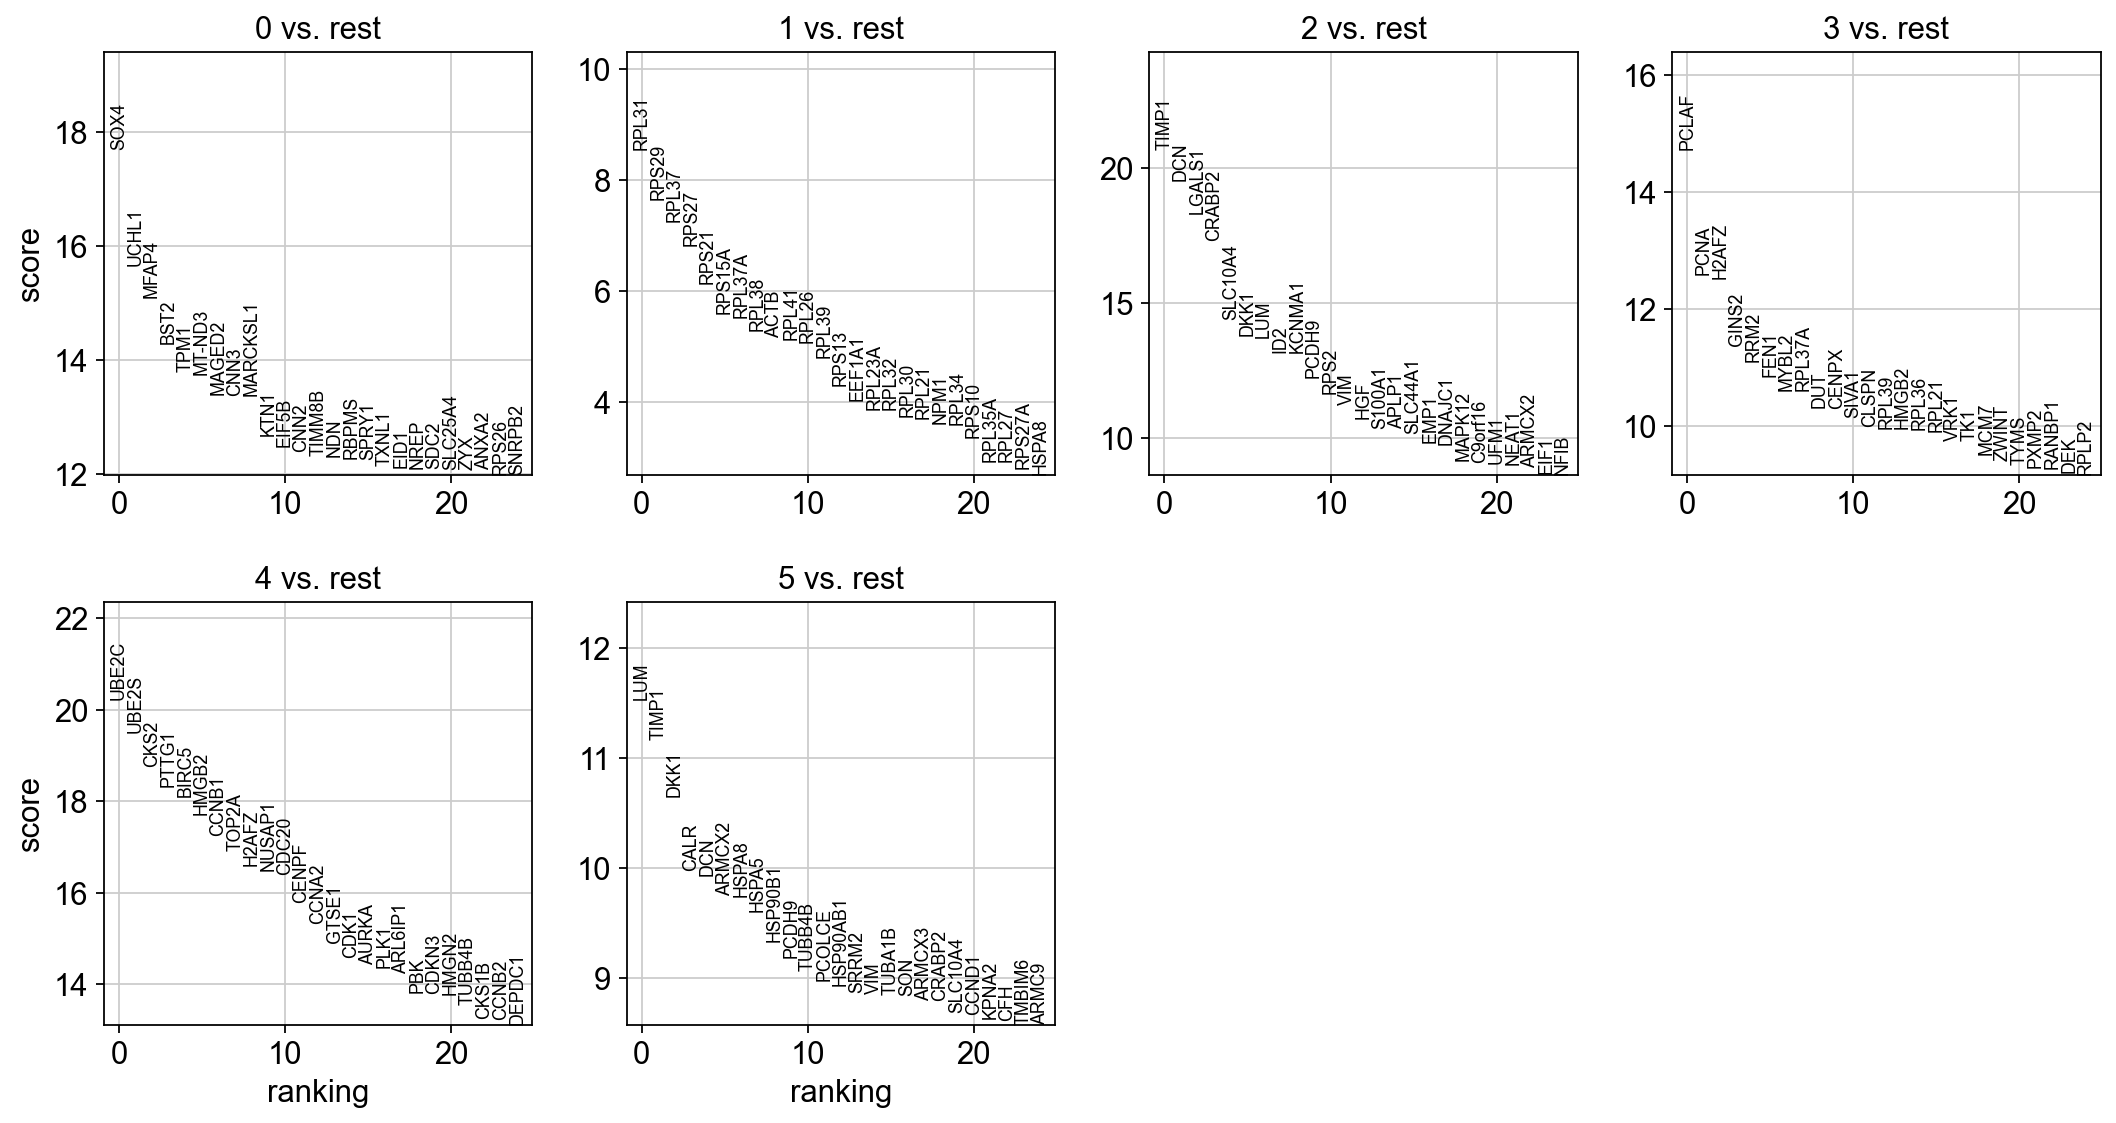

In [50]:
sc.tl.rank_genes_groups(filtered_adata, "leiden", method="wilcoxon")
sc.pl.rank_genes_groups(filtered_adata, n_genes=25, sharey=False)

In [51]:
filtered_adata.write(results_file)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
 (0:00:40)


C:\Users\xch\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


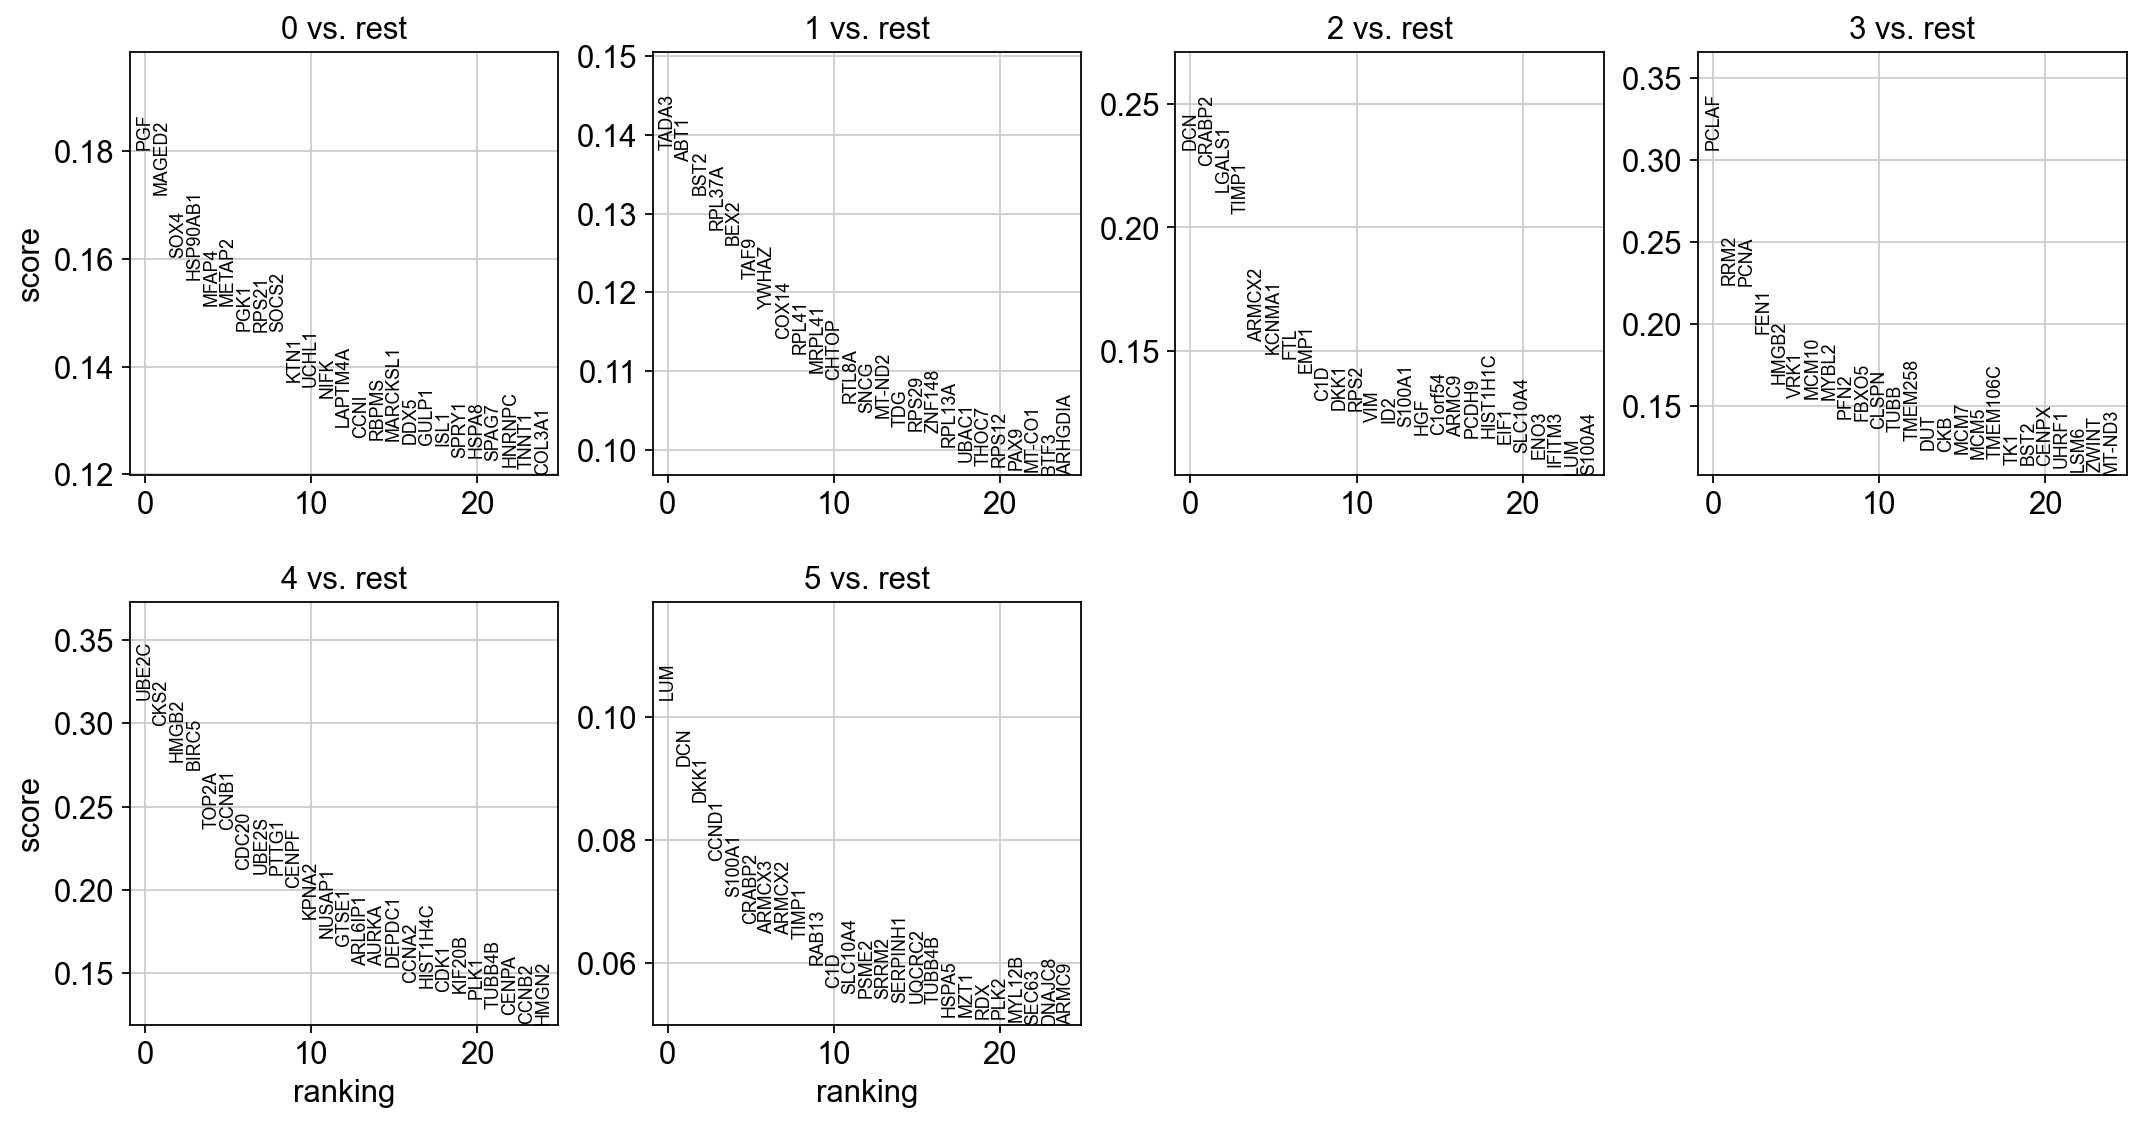

In [52]:
sc.tl.rank_genes_groups(filtered_adata, "leiden", method="logreg", max_iter=1000)
sc.pl.rank_genes_groups(filtered_adata, n_genes=25, sharey=False)

In [53]:
filtered_adata = sc.read(results_file)

In [54]:
pd.DataFrame(filtered_adata.uns["rank_genes_groups"]["names"]).head(5)

,0,1,2,3,4,5
0,SOX4,RPL31,TIMP1,PCLAF,UBE2C,LUM
1,UCHL1,RPS29,DCN,PCNA,UBE2S,TIMP1
2,MFAP4,RPL37,LGALS1,H2AFZ,CKS2,DKK1
3,BST2,RPS27,CRABP2,GINS2,PTTG1,CALR
4,TPM1,RPS21,SLC10A4,RRM2,BIRC5,DCN


In [55]:
result = filtered_adata.uns["rank_genes_groups"]
groups = result["names"].dtype.names
pd.DataFrame(
    {
        group + "_" + key[:1]: result[key][group]
        for group in groups
        for key in ["names", "pvals"]
    }
).head(5)

,0_n,0_p,1_n,1_p,2_n,2_p,3_n,3_p,4_n,4_p,5_n,5_p
0,SOX4,4.922566e-70,RPL31,1.180340e-17,TIMP1,4.536151e-95,PCLAF,3.848472e-49,UBE2C,5.299721e-91,LUM,8.845116e-31
1,UCHL1,2.957738e-55,RPS29,2.063444e-14,DCN,7.411069e-85,PCNA,2.279219e-36,UBE2S,1.059483e-84,TIMP1,5.592036e-29
2,MFAP4,1.573521e-51,RPL37,3.911694e-13,LGALS1,7.959252e-75,H2AFZ,5.589594e-36,CKS2,1.974444e-78,DKK1,1.630348e-26
3,BST2,2.606582e-46,RPS27,8.582219e-12,CRABP2,2.891689e-67,GINS2,4.661436e-30,PTTG1,6.533575e-75,CALR,1.888174e-23
4,TPM1,2.970119e-43,RPS21,8.322540e-10,SLC10A4,5.383644e-47,RRM2,1.189295e-28,BIRC5,3.484766e-73,DCN,3.038713e-23


ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:02)


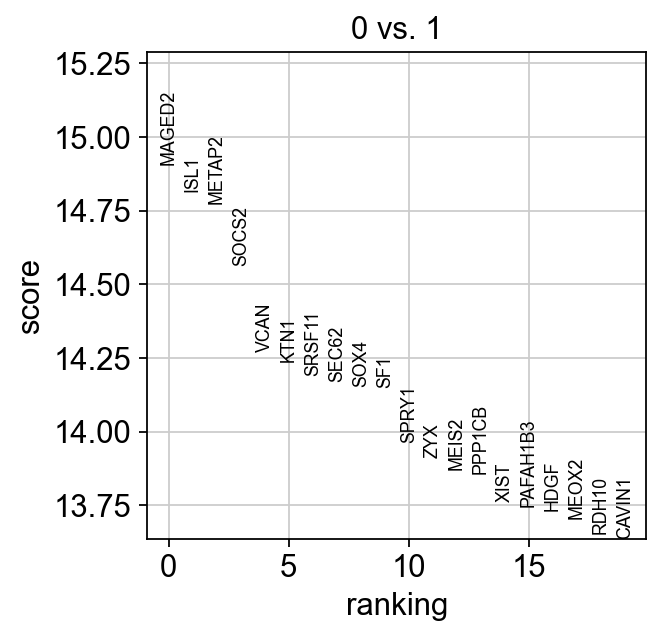

In [56]:
sc.tl.rank_genes_groups(filtered_adata, "leiden", groups=["0"], reference="1", method="wilcoxon")
sc.pl.rank_genes_groups(filtered_adata, groups=["0"], n_genes=20)

In [58]:
ranked_genes = [
    "SOX4",
    "UCHL1",
    "MFAP4",
    "TPM1"
]

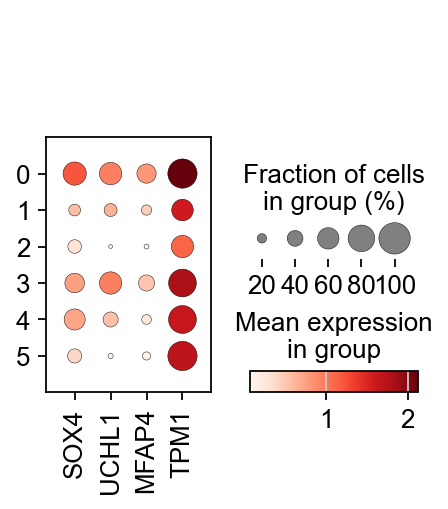

In [59]:
sc.pl.dotplot(filtered_adata,ranked_genes , groupby="leiden")